### 1D quadratic regression on NDP

In [1]:
import math
import einops
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
import torch.nn.functional as F
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Util codes

In [2]:
from scipy.spatial import distance

def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K

def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch

def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np

def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
    
print ("Ready")

Ready


`NDP` Equations 

Given state $s_t = (x_t, y_t)$, 

#### Forward diffusion process:
$$q(s_t|s_{t-1}) = \mathcal{N}\left(s_t; ~\sqrt{1-\beta_t}s_{t-1}, \beta_t I \right)$$

Due to fixed Markov chain $q(s_{0:T}) = q(s_0) \prod_{t=1}^T q(s_t | s_{t-1})$

Following satistified:
$$q(s_t|s_0) = \mathcal{N}\left( s_t; \sqrt{\bar{\alpha}_t} s_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

#### Reverse diffusion process posterior:
$$ 
q(s_{t-1}|s_t,s_0) 
= \mathcal{N}
\left(
s_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Approximating the mean with denosing model $\epsilon_\theta(s_t, t)$ it is possible to rewrite as backward kernel $p_\theta(s_{t-1} | s_t)$ as follows

$$
p_\theta(s_{t-1}|s_t) 
= \mathcal{N}
\left(
s_{t-1}; \frac{1}{\sqrt{\alpha_t}} (s_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(s_t, t)),
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)

$$

Default DDPM/NDP Regression Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=500$ 

Ready.


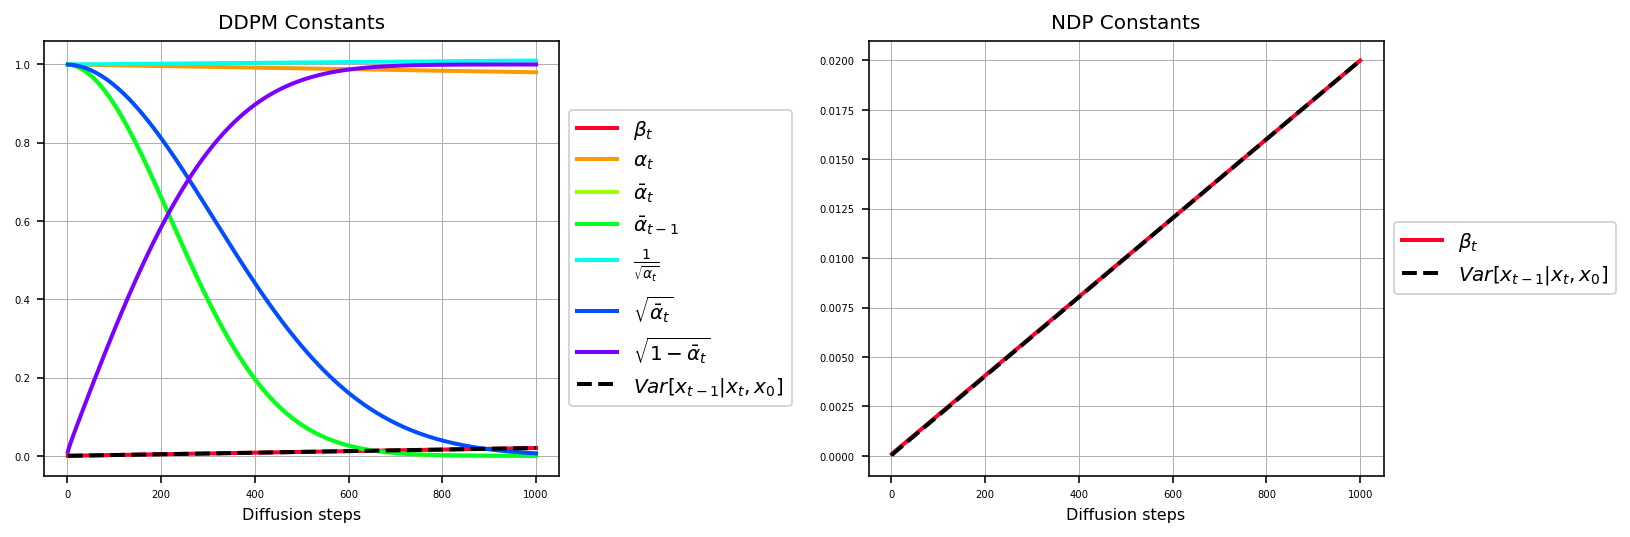

In [3]:
# Precompute some constants for NDP
dc = {}
# dc['T'] = 500
dc['T'] = 1000
dc['betas'] = torch.linspace(start=1e-4,end=2e-2,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### DDPM/NDP Regression using cosine beta scheduling hyper-parameters:
$T=500$, $t_i = i / T$, $t_{i+1} = (i+1) / T$, $\beta = \min(1 - \alpha(t_{i+1}) / \alpha(t_{i}), 0.999)$ and
$\alpha(t) = cos\left( \frac{t + 0.008}{1.008} \cdot \frac{\pi}{2} \right)^2$

Ready.


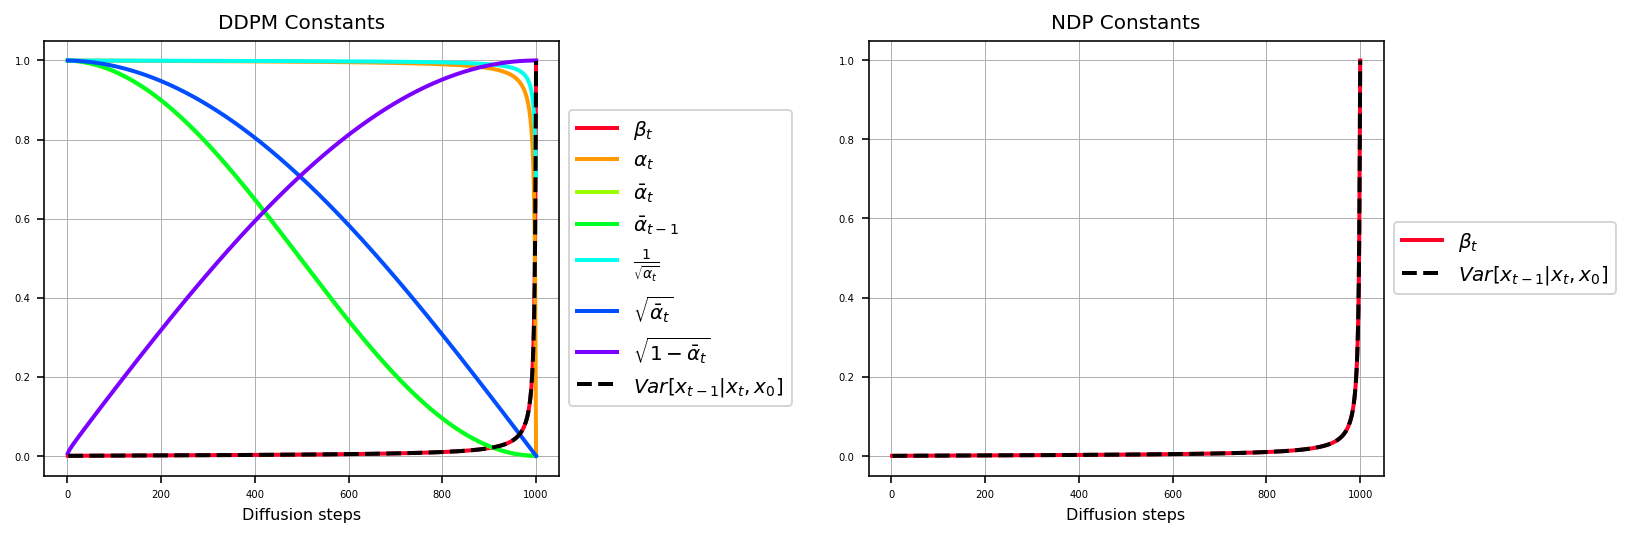

In [28]:
# Precompute some constants for NDP
# Cosine Beta scheduling
def alpha_bar(t):
    return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2 / (math.cos((0.008) / 1.008 * math.pi / 2) ** 2)

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.clamp(torch.tensor(betas),0,0.999)

dc = {}
dc['T'] = 1000
dc['betas'] = betas_for_alpha_bar(dc['T'], alpha_bar=alpha_bar, max_beta=0.999)
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/(1.0 - 1e-5 + dc['betas'])) # [T]
# dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
# dc['sqrt_recip_alphas'] = torch.clamp(torch.sqrt(1.0/dc['alphas']), max=1.1)
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
# dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar'])/(1.0-dc['alphas_bar_prev']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$, $\phi \sim p_\phi$, $\mathbf{y}_0 \sim \mathcal{N}(\mathbf{0}, k_\phi(\mathbf{x}_0, \mathbf{x}_0) + \sigma^2 \mathbf{I})$\
2: $\bar{\alpha_t} = \prod_{s=1}^t(1-\beta_s)$, $\gamma_t = \sqrt{1 - \bar{\alpha_t}}$, and $t \sim \text{Uniform}(\{ 1, \ldots, T \})$,\

3: $ \boldsymbol{\color{red} \epsilon_x, \color{blue} \epsilon_y} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \

$\bold{Case 1}$: If only diffuse on the observations, \
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$ \
5: Take gradient descent step on the observation
$$ 
    \nabla \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2
$$
$\bold{Case 2}$: If diffuse both on sample and observations,\
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$, and  $\mathbf{x}_t = \sqrt{\bar{\alpha_t}}\mathbf{x}_0 + \gamma_t \boldsymbol{\color{red} \epsilon_x} $ \
5: Take gradient descent step on both input and observations

$$ 
    \nabla \left[ \| \boldsymbol{\color{red} \epsilon_x} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon_x}, t
        ) \|^2
    + \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2 
    \right]
$$

## TODO: Fix prior sampling part for NDP
### `Algorithm 2` Sampling 
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Forward diffusion sampler

In [4]:
def forward_diffusion_sample(x_0, steps, dc):
    """
        x_0: torch.Tensor [B x D x L]
        K_chols: torch.Tensor [D x L x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x D x L]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x D x L]
    noise = torch.randn_like(input=x_0) # [B x D x L]

    x_t = x_t_mean + x_t_std * noise
    return x_t, noise


### Define Quadratic Dataset
$f(x) := ax^2 + \epsilon$, where $a \sim U(\{-1, 1\})$ and $\epsilon \sim N(0, 1)$


In [5]:
class QuadraticDataset(torch.nn.Module):
    def __init__(self, num_data, num_points, seed=42):
        super().__init__()

        self.num_data = num_data
        self.num_points = num_points
        self.seed = seed
        self.x = torch.linspace(start=-10., end=10., steps=self.num_points).unsqueeze(0).repeat(self.num_data, 1)
        self.dataset = self._create_dataset()
    
    def _create_dataset(self):
        torch.manual_seed(self.seed)
        a = torch.randint(low=0, high=2, size=(self.x.shape[0], 1)).repeat(1, self.num_points) * 2 - 1
        eps = torch.normal(mean=0., std=1., size=(self.x.shape[0], 1)).repeat(1, self.num_points)

        y = a * (self.x ** 2) + eps
        return y
            
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, idx):
        
        return self.x[idx, :].unsqueeze(-1), self.dataset[idx, :].unsqueeze(-1)

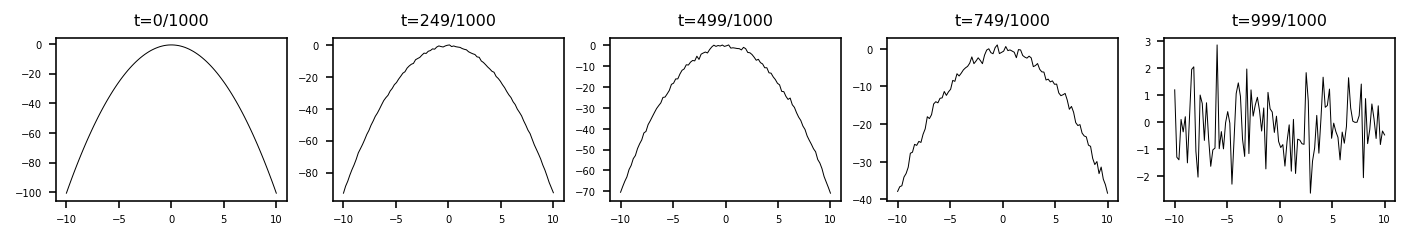

In [6]:
# Check forward diffusion

check_data = QuadraticDataset(num_data=1, num_points=100)
x_0, y_0 = check_data[0]

steps = torch.linspace(start=0, end=dc['T']-1, steps=dc['T']//200).long()

plt.figure(figsize=(12,1.5))
for i, step in enumerate(steps):
    t = int(step.item())
    y_t_mean = dc['sqrt_alphas_bar'][t] * y_0 
    y_t_std = dc['sqrt_one_minus_alphas_bar'][t]
    noise = torch.randn_like(x_0)
    y_t = y_t_mean + y_t_std * noise 
    
    plt.subplot(1, len(steps), i+1)
    plt.plot(torch2np(x_0)[:,0], torch2np(y_t)[:,0], color='k', lw=1/2)
    plt.title('t=%d/%d'%(torch2np(step),dc['T']),fontsize=8)
plt.show()

### Network - Official code implemented in PyTorch with minor modifications from previous implementation

#### Notation
- N : the sequence length
- D : input dimension
- H : the hidden embedding dimension

In [7]:
class MultiHeadSelfAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads  = num_heads
        head_dim        = dim // num_heads
        self.scale      = head_dim ** -0.5

        # self.q          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.k          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.v          = nn.Linear(dim, dim, bias=qkv_bias)
        self.qkv        = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.attn_drop  = nn.Dropout(attn_drop)
        self.proj       = nn.Linear(dim, 2 * dim)
        self.proj_drop  = nn.Dropout(proj_drop)        

    def forward(self, s):
        
        B, N, D, H = s.shape
        qkv = self.qkv(s).reshape(B, N, D, 3, self.num_heads, H//self.num_heads)
        # print(f'qkv size = {qkv.size()}')
        qkv = qkv.permute(3, 0, 4, 1, 2, 5)
        # print(f'qkv size = {qkv.size()}')
        q, k, v = qkv.unbind(0)
        # print(f'q size = {q.size()}, k size = {k.size()}, v size = {v.size()}')

        
        attn_score = (q @ k.transpose(-2, -1)) * self.scale
        # print(f'attention score size = {attn_score.size()}')
        attn_score = attn_score.softmax(dim=-1)
        attn_score = self.attn_drop(attn_score)

        # attention on dim D
        attn = (attn_score @ v).transpose(2, 3).reshape(B, N, D, H)
        # print(attn.size())
        attn = self.proj(attn)
        attn = self.proj_drop(attn)
        return attn

class BiDimensionalAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., norm = 'layernorm', activation='relu', pre_norm = True):
        super().__init__()
        self.MHSA_D = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)
        self.MHSA_N = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)

        self.norm = self._get_norm_layer(norm, dim)
        self.activation = self._get_act_fn(activation)
        self.pre_norm = pre_norm
        
        self.t_embed = nn.Linear(dim, dim)

    def forward(self, s, t):
    
        t = self.t_embed(t)[:, None, None, :] # ensure the shape of t should be [batch_size, 1, 1, H]
        s_t = s + t # ensure the shape of t should be [batch_size, N, D, H]

        y_d = self.MHSA_D(s_t)
        y_n = self.MHSA_N(s_t.transpose(1, 2)).transpose(1, 2)

        a = y_d + y_n
        residual, skip = torch.tensor_split(a, 2, dim=-1)
        residual = self.activation(residual)
        skip = self.activation(skip)

        return (s + residual) / math.sqrt(2.0), skip


    def _get_norm_layer(self, norm, dim):
        if norm.lower() == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm.lower() == 'batchnorm':
            return nn.BatchNorm1d()
        else:
            return nn.Identity()

    def _get_act_fn(self, activation):
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'silu':
            return nn.SiLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        else:
            raise NotImplementedError 


class NDPModel(nn.Module):
    def __init__(self,
                 name        = 'neural_diffusion_process_fixed',
                 D           = 3,
                 L           = 100,
                 pos_emb_dim = 128,
                 hidden_dim  = 64,
                 n_layers    = 5,
                 num_heads   = 8,
                 qkv_bias    = False,
                 attn_drop   = 0.,
                 proj_drop   = 0.,
                 norm        = 'layernorm',
                 activation  = 'relu',
                 pre_norm    = True,
                 actv        = nn.ReLU(),
                ):
        super().__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.num_heads   = num_heads
        self.qkv_bias    = qkv_bias
        self.attn_drop   = attn_drop
        self.proj_drop   = proj_drop
        self.norm        = norm
        self.activation  = activation
        self.pre_norm    = pre_norm
        self.actv        = actv
        
        # Initialize layers
        self.init_layers()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()

        # Preprocess embedding layer
        # If y as a prior is given
        self.layers['Preprocess'] = nn.Sequential(
            nn.Linear(2, self.hidden_dim),
            nn.GELU(),
        )
    
        # If only x is given
        # self.layers['Preprocess'] = nn.Sequential(
        #     nn.Linear(1, self.hidden_dim),
        #     nn.GELU(),
        # )

        # Bi-dimensional attention blocks
        for i in range(self.n_layers):
            self.layers['Attn_block_%02d'%(i)] = BiDimensionalAttentionClass(
                dim=self.hidden_dim, num_heads=self.num_heads, qkv_bias=self.qkv_bias,
                attn_drop=self.attn_drop, proj_drop=self.proj_drop, norm=self.norm,
                activation=self.activation, pre_norm=self.pre_norm)
        
        # Out
        self.layers['Out'] = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1, bias=False),)
        

    def forward(self, x, y, t):
        """
            Forward
        """
        s = self.preprocess(x, y) if y is not None else x.unsqueeze(-1)
        s = self.layers['Preprocess'](s)
        
        #TODO: check whether time embedding should be passed dense layer from pos_emb_dim -> hidden_dim
        t_embed = self.time_embed(t)

        # outs = torch.zeros_like(s)

        skip = None
        for i in range(self.n_layers):
            s, skip_connection = self.layers['Attn_block_%02d'%(i)](s, t_embed)
            skip = skip_connection if skip is None else skip_connection + skip

        skip = einops.reduce(skip, "b n d h -> b n h", "mean")

        eps = skip / math.sqrt(self.n_layers * 1.0)
        eps = self.layers['Out'](eps)
        return eps
    
    
    def preprocess(self, x, y):
        D = x.shape[-1] # num x_dim
        x = x.unsqueeze(-1) 
        y = torch.repeat_interleave(y.unsqueeze(-1), D, axis=2)
        conc = torch.cat([x, y], dim=-1)

        return conc

    def time_embed(self, steps, max_positions=10000):
        '''
        steps: random time step t with shape (batch_size,)
        max_positions: log(10000) = 4
        '''
        device = steps.device
        # half_dim = self.pos_emb_dim // 2
        half_dim = self.hidden_dim // 2

        # Before the official code releases
        # embeddings = torch.pow(10, torch.arange(half_dim, device=device, dtype=torch.float32) * 4 / (half_dim - 1))
        # After the official code releases
        # emb = jnp.log(max_positions) / (half_dim - 1)
        embeddings = np.log(max_positions) / (half_dim - 1)
        # emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
        embeddings = torch.exp(torch.arange(half_dim, device=device, dtype=torch.float32) * -embeddings)

        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # if self.pos_emb_dim % 2 == 1:
        if self.hidden_dim % 2 == 1:
            embeddings = F.pad(embeddings, [[0, 0], [0, 1]])
        
        # assert embeddings.shape == (steps.shape[0], self.pos_emb_dim)
        assert embeddings.shape == (steps.shape[0], self.hidden_dim)
        return embeddings


print ("Ready.")    

Ready.


### Define loss function 

In [8]:
def get_regression_loss(model, x_0, y_0, t, dc, loss_type='l2'):
    """
        x_0: [B x D x L]
    """
    # Forward diffusion

    # TODO: Diffuse only function values y - x can be diffuse in NDP
    # x_noisy,x_noise = forward_hilbert_diffusion_sample(
    #     x_0=x_0, K_chols=K_chols, steps=t, dc=dc, noise_rate=1.0, hilbert_sampling=hilbert_sampling) # [B x D x L]
    
    # y_t, noise
    y_noisy, y_noise = forward_diffusion_sample(x_0=y_0, steps=t, dc=dc) # [B x 1 x L]
 
    # Predict noise
    noise_pred = model(x=x_0, y=y_noisy, t=t) # [B x L X 1]

    # Compute loss
    if loss_type == 'l1':
        loss = F.l1_loss(y_noise, noise_pred)
    elif loss_type == 'l2':
        loss = F.mse_loss(y_noise, noise_pred)
    elif loss_type == 'huber':
        loss = F.huber_loss(y_noise, noise_pred)
    else:
        raise NotImplementedError(f'Loss type should be [l1, l2, huber]] but got {loss_type}')
    return loss
print ("Ready")

Ready


### Train

In [9]:
def check_grad(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().cpu().numpy().mean())
            
    if max(ave_grads) > 1.0:
       print(max(ave_grads))

In [12]:
!pip install -U pytorch_warmup
import pytorch_warmup as warmup

In [10]:
# Train

device = 'cuda:5' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE, L, D, MAX_ITER = 32, 100, 1, 250
model = NDPModel(D=D, L=L, activation='gelu', norm='none').to(device)
print ("[%s] instantiated."%(model.name))

train_dataset = QuadraticDataset(num_data=4096, num_points=100, seed=42)
valid_dataset = QuadraticDataset(num_data=100, num_points=100, seed=43)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.Adam(
    model.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-06)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optmimizer, T_0=20)
num_steps = len(train_loader) * MAX_ITER

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)

# warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=20)


train_losses = []
val_losses = []

check_epoch = MAX_ITER // 20

for it in range(MAX_ITER):
    train_loss, valid_loss = 0.0, 0.0
    num_train, num_valid = 0, 0

    model.train()
    for x_0, y_0 in train_loader:
        x_0 = x_0.to(device)
        y_0 = y_0.to(device) / 50

        optimizer.zero_grad()

        t = torch.randint(0, dc['T'],(x_0.shape[0],),device=device).long() # [B]
        loss = get_regression_loss(model=model, x_0=x_0, y_0=y_0, t=t, dc=dc)
        loss.backward()
        check_grad(model.named_parameters())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        # with warmup_scheduler.dampening():
        #     scheduler.step()


        train_loss += loss.item() * x_0.size(0)
        num_train += x_0.size(0)
    
    avg_loss = train_loss/num_train
    train_losses.append(avg_loss)

    if (it % check_epoch) == 0:
        print ("[%d/%d] train loss:[%.3f]"%(it,MAX_ITER,avg_loss))

    model.eval()
    with torch.no_grad():
        for x_0, y_0 in valid_loader:
            x_0 = x_0.to(device)
            y_0 = y_0.to(device) / 50
            
            t = torch.randint(0, dc['T'],(x_0.shape[0],),device=device).long()
            val_loss = get_regression_loss(model=model, x_0=x_0, y_0=y_0, t=t, dc=dc)
            valid_loss += val_loss.item() * x_0.size(0)
            num_valid += x_0.size(0)

        avg_loss = valid_loss/num_valid
        val_losses.append(avg_loss)

    if (it % check_epoch) == 0:
         print ("[%d/%d] validation loss:[%.3f]"%(it,MAX_ITER,avg_loss))

torch.save(model.state_dict(), '/home/seungwoos/yet-another-diffusion-models/checkpoints/ndp_quadratic_cosine_T_1000_l2_loss.pth')
print ("Done.")

[neural_diffusion_process_fixed] instantiated.
[0/250] train loss:[0.997]
[0/250] validation loss:[0.977]
[12/250] train loss:[0.068]
[12/250] validation loss:[0.093]
[24/250] train loss:[0.049]
[24/250] validation loss:[0.053]
[36/250] train loss:[0.042]
[36/250] validation loss:[0.039]
[48/250] train loss:[0.034]
[48/250] validation loss:[0.030]
[60/250] train loss:[0.028]
[60/250] validation loss:[0.028]
[72/250] train loss:[0.026]
[72/250] validation loss:[0.026]
[84/250] train loss:[0.023]
[84/250] validation loss:[0.021]
[96/250] train loss:[0.021]
[96/250] validation loss:[0.029]
[108/250] train loss:[0.020]
[108/250] validation loss:[0.021]
[120/250] train loss:[0.015]
[120/250] validation loss:[0.015]
[132/250] train loss:[0.014]
[132/250] validation loss:[0.011]
[144/250] train loss:[0.013]
[144/250] validation loss:[0.011]
[156/250] train loss:[0.011]
[156/250] validation loss:[0.010]
[168/250] train loss:[0.011]
[168/250] validation loss:[0.009]
[180/250] train loss:[0.009]

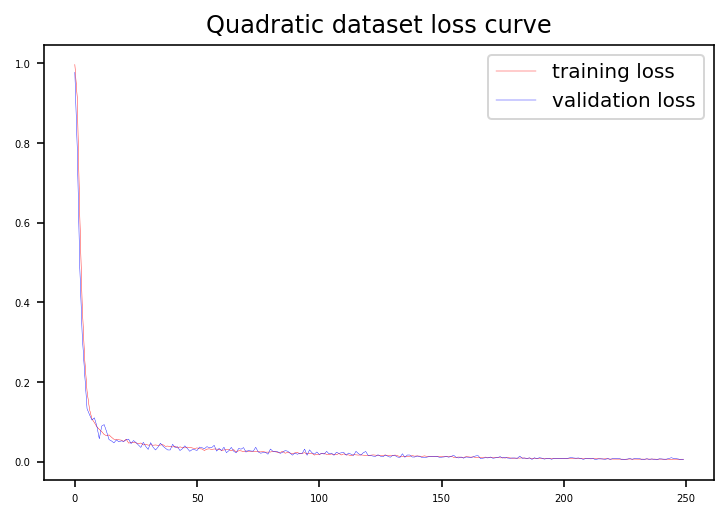

In [11]:
num_iter = range(MAX_ITER)
plt.plot(num_iter, train_losses, '-r', linewidth='0.2', label='training loss')
plt.plot(num_iter, val_losses, '-b', linewidth='0.2', label='validation loss')
plt.title('Quadratic dataset loss curve')
plt.legend(loc='upper right')
plt.show()

### Generation

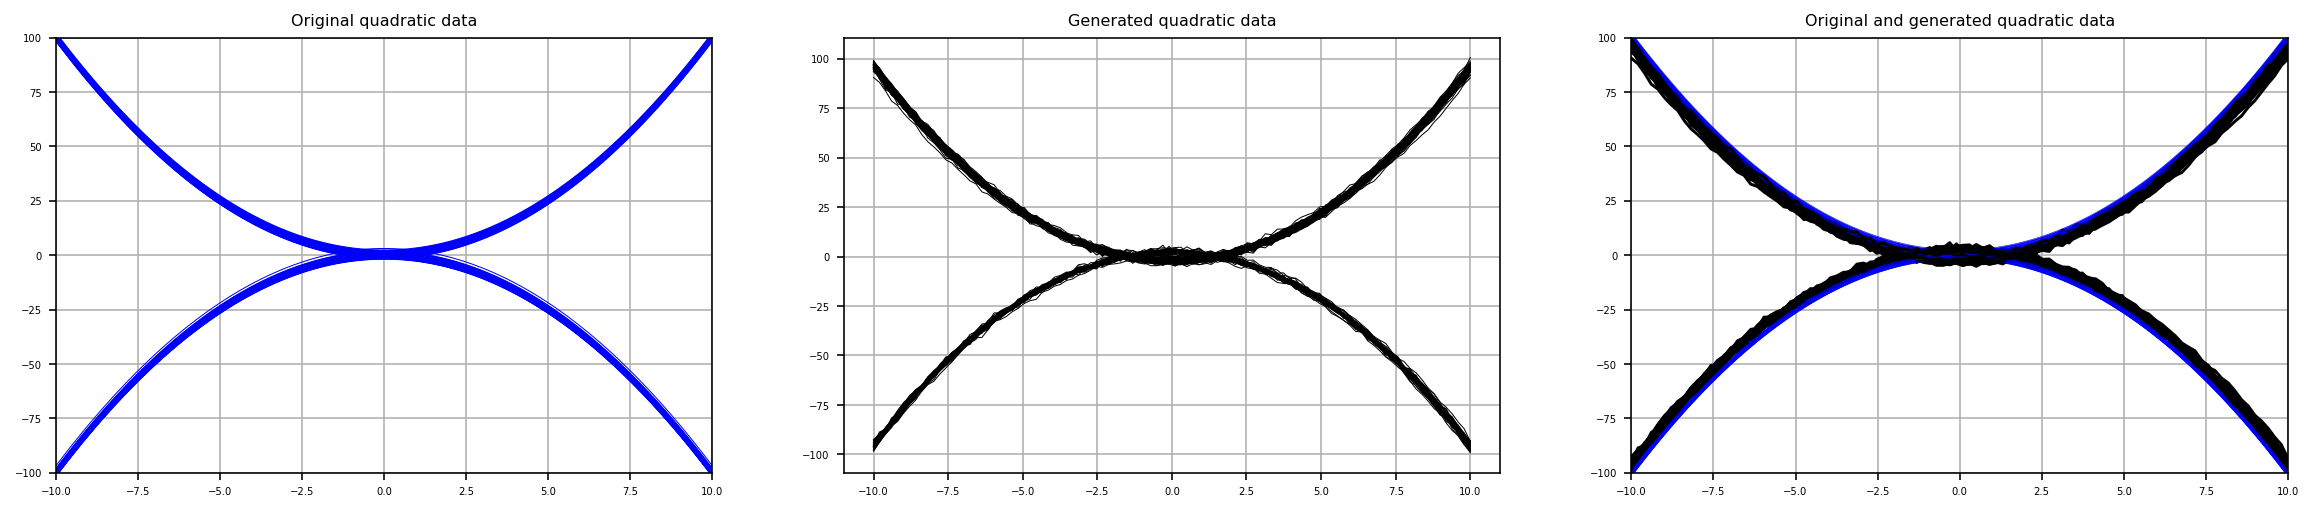

In [67]:
device = 'cuda:4'

from tqdm import tqdm

B,D,L = 100, 1, 100
# Sample x_T from prior
# model = NDPModel(D=D, L=L, activation='gelu', norm='none')
# model.load_state_dict(torch.load('/home/seungwoos/yet-another-diffusion-models/checkpoints/ndp_quadratic_cosine_T_1000_linear_warmup.pth'))

y_t_s = []
y_0_s = []

test_dataset = QuadraticDataset(num_data=B*10, num_points=100, seed=44)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=B, shuffle=False)

for x_0, y_0 in test_loader:
    x_t = x_0.clone().to(device) 

    noise = torch.randn_like(y_0) # [B x D x L]
    y_t = noise.clone().to(device)

    steps = torch.zeros(B).type(torch.long) # [B]
    model.to(device)
    model.eval()

    # Generate
    # y_ts = ['']*dc['T']
    for t in range(1,dc['T'])[::-1]:
        t_torch = torch.full((1,), t,device=device,dtype=torch.long)

        y_t = y_t.to(device)
        eps_t = model(x=x_t,y=y_t, t=t_torch) # [B x L X D]

        eps_t = eps_t.cpu().detach()
        # Diffusion constants
        betas_t = gather_and_reshape(
            values=dc['betas'],steps=t_torch,x_shape=x_t.shape).cpu() # [B x 1 x 1]
        sqrt_one_minus_alphas_bar_t = gather_and_reshape(
            values=dc['sqrt_one_minus_alphas_bar'],steps=t_torch,x_shape=x_t.shape).cpu()

        sqrt_recip_alphas_t = gather_and_reshape(
            values=dc['sqrt_recip_alphas'],steps=t_torch,x_shape=x_t.shape).cpu()
        y_t = y_t.cpu()
        # Compute posterior mean
        model_mean_t = sqrt_recip_alphas_t * (
            y_t - betas_t*eps_t/sqrt_one_minus_alphas_bar_t
        ) # [B x D x L]
        noise_t = torch.randn_like(y_t)

        # Compute posterior variance
        posterior_variance_t = gather_and_reshape(
            values=dc['posterior_variance'],steps=t_torch,x_shape=x_t.shape).cpu()
        # Sample

        y_t = model_mean_t + torch.sqrt(posterior_variance_t) * noise_t

    y_t *= 50

# Append
# y_ts[t] = y_t # [B x D x L]
    y_t_s.append(y_t)
    y_0_s.append(y_0)
    
    # Plot original and generated data
for d_idx in range(D):
    # for b_idx in range(B):
    plt.figure(figsize=(20,4))        
    plt.subplot(1,3,1)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/2); 
    plt.grid('on')
    plt.title('Original quadratic data', fontsize=8); 
    plt.xlim(-10,10); plt.ylim(-100, 100)

    plt.subplot(1,3,2)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k',lw=1/2); 
    plt.grid('on')
    plt.title('Generated quadratic data', fontsize=8); 
    # plt.xlim(-10,10); plt.ylim(-100, 100)


    plt.subplot(1,3,3)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/4); 
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k'); plt.grid('on')
    plt.title('Original and generated quadratic data',fontsize=8); 
    plt.xlim(-10,10); plt.ylim(-100, 100)
plt.show()


In [68]:
y_t = torch.stack(y_t_s).reshape(-1, 100, 1)
x_0, y_0 = test_dataset[:]

print(y_0.shape, y_t.shape)

torch.Size([1000, 100, 1]) torch.Size([1000, 100, 1])


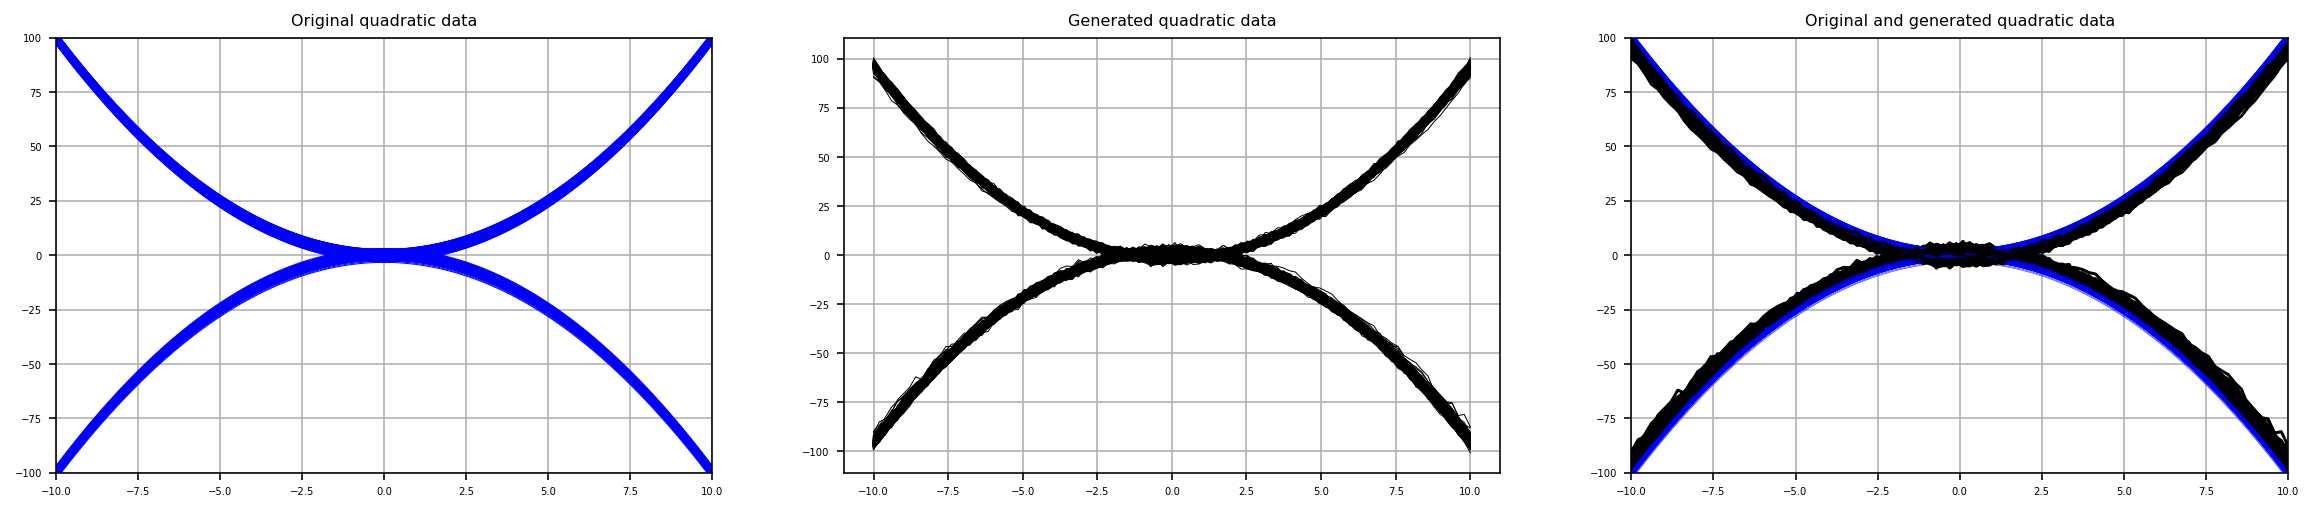

In [69]:
for d_idx in range(D):
    # for b_idx in range(B):
    plt.figure(figsize=(20,4))        
    plt.subplot(1,3,1)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/2); 
    plt.grid('on')
    plt.title('Original quadratic data', fontsize=8); 
    plt.xlim(-10,10); plt.ylim(-100, 100)

    plt.subplot(1,3,2)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k',lw=1/2); 
    plt.grid('on')
    plt.title('Generated quadratic data', fontsize=8); 
    # plt.xlim(-10,10); plt.ylim(-100, 100)


    plt.subplot(1,3,3)
    for m_idx in range(x_0.shape[0]):
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_0)[m_idx,:,d_idx],ls='-',color='b',lw=1/4); 
        plt.plot(torch2np(x_0)[m_idx,:,d_idx],torch2np(y_t)[m_idx,:,d_idx],ls='-',color='k'); plt.grid('on')
    plt.title('Original and generated quadratic data',fontsize=8); 
    plt.xlim(-10,10); plt.ylim(-100, 100)
plt.show()

In [70]:
from scipy.stats import percentileofscore 
from sklearn.metrics import pairwise_distances

def K_ID(X, Y, gamma=1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the identity operator
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel, if -1 then median heuristic is used to pick gamma
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    if gamma == -1:
        gamma = np.median(dist_mat[dist_mat > 0])
   
    K = np.exp(-0.5 * (1 / gamma ** 2) * (dist_mat ** 2))
    return K

def MMD_K(K, M, N):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    M - number of samples from first distribution
    N - number of samples from first distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """
    
    Kxx = K[:N,:N]
    Kyy = K[N:,N:]
    Kxy = K[:N,N:]
    
    t1 = (1. / (M * (M-1))) * np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2. / (M * N)) * np.sum(Kxy)
    t3 = (1. / (N * (N-1))) * np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

def two_sample_test(X, Y, hyp, n_perms, z_alpha = 0.05, make_K = K_ID, return_p = False):
    """
    Performs the two sample test and returns an accept or reject statement
    
    Parameters:
    X - (n_samples, n_obs) array of samples from the first distribution 
    Y - (n_samples, n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    return_p - option to return the p-value of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    
    Returns:
    rej - 1 if null rejected, 0 if null accepted
    p-value - p_value of test
    
    """
    
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]

    K = make_K(X, Y, hyp)

    # Empirical MMD^{2} calculated
    MMD_test = MMD_K(K, M, N)
    
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    for i in range(n_perms):
            idx = np.random.permutation(M+N)
            K = K[idx, idx[:, None]]
            shuffled_tests[i] = MMD_K(K,M,N)
    
    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0-z_alpha)
    rej = int(MMD_test > q)
    
    if return_p:
        p_value = 1-(percentileofscore(shuffled_tests,MMD_test)/100)
        return rej, p_value
    else:
        return rej

def power_test(X_samples,Y_samples,gamma,n_tests,n_perms,z_alpha = 0.05,make_K = K_ID,return_p = False):
    """
    Computes multiple two-sample tests and returns the rejection rate
    
    Parameters:
    X_samples - (n_samples*n_tests,n_obs) array of samples from the first distribution 
    Y_samples - (n_samples*n_tests,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_tests - number of tests to perform
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    return_p - option to return the p-value of the test
    
    Returns:
    power - the rate of rejection of the null
    """
    
    # Number of samples of each distribution is identified
    M = int(X_samples.shape[0]/n_tests)
    N = int(Y_samples.shape[0]/n_tests)
    rej = np.zeros(n_tests)

    domain = np.linspace(-10, 10, 100)
    # For each test, extract the data to use and then perform the two-sample test
    for t in range(n_tests):
        X_t = np.array(X_samples[t*M:(t+1)*M,:])
        Y_t = np.array(Y_samples[t*N:(t+1)*N,:])
        rej[t] = two_sample_test(X_t,Y_t,gamma,n_perms,z_alpha = z_alpha,make_K = make_K,return_p = return_p)

        reject = 'reject' if int(rej[t]) == 1 else 'not reject'
        print(reject)
        plt.figure(figsize=(12,4))
        X_t_label = 'Ground truth'
        Y_t_label = 'Generation'

        for i in range(M):
            plt.plot(domain, X_t[i, :],'-',color='red', label=X_t_label)
            plt.plot(domain, Y_t[i, :],'-',color='blue', label=Y_t_label)
            X_t_label = '_nolegend_'
            Y_t_label = '_nolegend_'
        plt.legend(loc='upper right')  
        plt.ylim([-105, 105]) 
        plt.show()

    # Compute average rate of rejection
    power = np.mean(rej)
    return power

In [ ]:
X = torch2np(y_0).squeeze(-1) # ground truth -> reduce dimension [B, N, D] -> [B, N]
Y = torch2np(y_t).squeeze(-1) # prediction -> redice dimension [B, N, D] -> [B, N]

assert len(X.shape) == 2
assert len(Y.shape) == 2

n_tests = X.shape[0] // 10
n_perms = 100
gamma = -1

power = power_test(X_samples=X, Y_samples=Y, gamma=gamma, n_tests=n_tests, n_perms=n_perms)
print(f'Power = {power * 100:.5f}%')